### Project 3

In [16]:
################################################################
import datetime
from datetime import datetime
import numpy as np
import pandas as pd
import patsy
import re
import glob

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

from itertools import cycle
from sklearn.linear_model import lasso_path, enet_path

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

# make sure charts appear in the notebook:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [ ]:
#1, 2, 3, 4, 5

In [17]:
# concatenate all assessor csvs from 2007 to 2015
# assessor data: contains information about yearly house assessments
# includes attributes of each house: bed no., room no., value, etc.

path = "/Users/ga/Desktop/san_francisco/assessor_office/"

files = []
for i in range(2007, 2015):
    file_name = "assessor_data_" + str(i) + "_" + str(i+1) + ".csv"
    files.append(file_name)

list_ = []
#frame = pd.DataFrame()
for f in files:
    allFiles = glob.glob(path + f)

    for file_ in allFiles:
        df = pd.read_csv(file_, index_col=None)
        #df["YEAR"] = pd.Series(i, index = df.index)
        list_.append(df)
        #print file_, df.columns

assessor = pd.concat(list_)

#assessor["YEAR"].unique 

#assessor.isnull().sum()

In [18]:
# CLEAN, CLEAN, CLEAN...

assessor.drop(["BASELOTSFX", "BUILTIN", "CONSTTYPE", "EXEMPTYPE",
               "KITCHEN", "LOTCODE", "REMARKFLA", "REPRISDATE",
               "RP1CLACDE", "RP1DOCNO1", "RP1NBRCDE",
               "RP1STACDE", "ZONE", "PROPLOC", "RP1PRCLID",
               "OWNRPRCNT", "RECURRSALD", "RP1TRACDE"], axis = 1, inplace=True)

assessor["BASELOT"] = assessor["BASELOT"].fillna(np.mean(assessor["BASELOT"]))
assessor["FBA"] = assessor["FBA"].fillna(np.mean(assessor["FBA"]))
assessor["LAREA"] = assessor["LAREA"].fillna(np.mean(assessor["LAREA"]))

def replace_zeros(df, my_cols):
    for col in my_cols:
        col_nonzero_mean = assessor[col][assessor[col] != 0].mean()
        assessor[col].replace(0, col_nonzero_mean, inplace=True)
    return df 

cols = ["RP1DOCNO2", "ROOMS", "STOREYNO", "SQFT", "UNITS", "BATHS", "YRBLT",
            "BEDS", "DEPTH", "FRONT", "RP1EXMVL2"]

replace_zeros(assessor, cols)

print assessor.shape

assessor = assessor.dropna(axis = 0, how = "any").reset_index(drop=True)

yr_dict = {95: 1995, 13: 1913, 9185: 1985, 6889: 1989, 6573: 1973,
           8687: 1987, 24: 1924, 21: 1921, 22: 1922, 41: 1941}

assessor["YRBLT"].replace(yr_dict, inplace=True)
assessor = assessor[assessor["YRBLT"] < 2017]
assessor = assessor[assessor["YRBLT"] > 1600]

valcols = ["RP1FXTVAL", "RP1IMPVAL", "RP1LNDVAL", "RP1PPTVAL"]
assessor["VALUE"] = assessor[valcols].sum(axis=1)
assessor = assessor.iloc[:, ~assessor.columns.isin(valcols)]

#print assessor.shape (1483188, 20)
    
#for col in ["RP1DOCNO2", "ROOMS", "STOREYNO", "SQFT", "UNITS", "BATHS", "YRBLT",
#            "BEDS", "DEPTH", "FRONT", "RP1EXMVL2"]:
#     assessor = assessor[assessor[col] != 0]

assessor = assessor[assessor["VALUE"] > 20000].reset_index(drop=True)

print assessor.shape #(1154771, 20)


(1612110, 23)
(1504564, 20)


In [19]:
sns.set_style("darkgrid", {"text.color": ".1"})

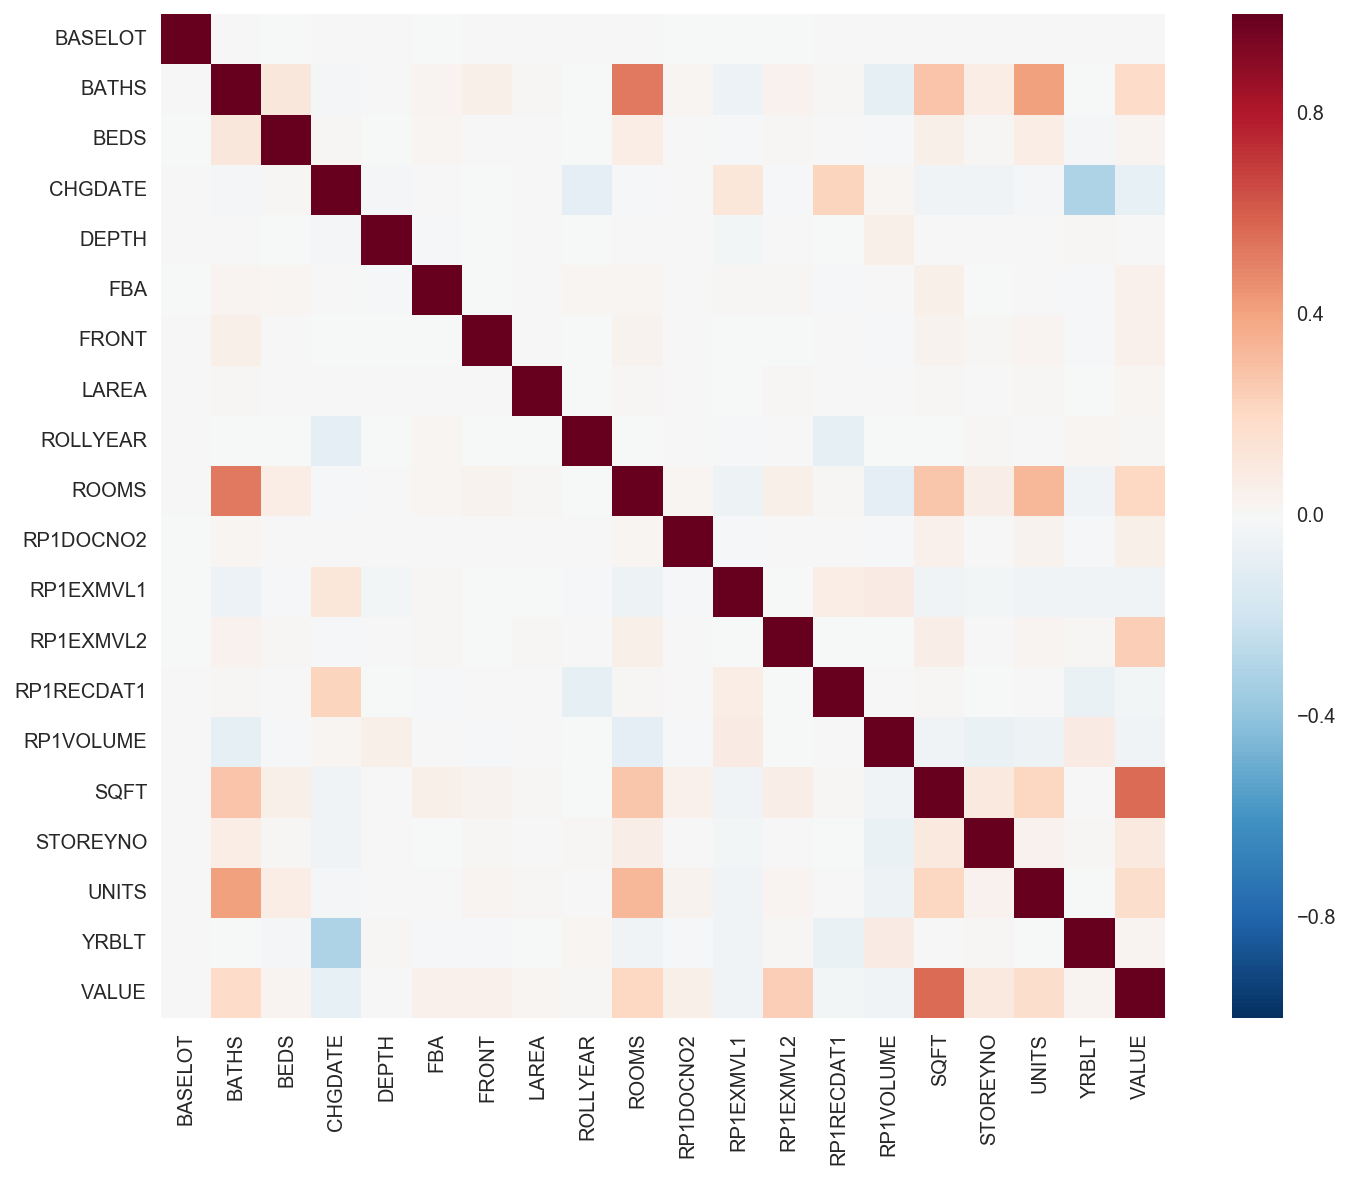

In [120]:
# visualize correlation among features

corrmat = assessor.corr()
f, ax = plt.subplots(figsize = (12,9))
sns.heatmap(corrmat, square = True)
plt.xticks(rotation='vertical')
plt.yticks(rotation = 0)
sns.plt.show()

In [20]:
# create the predictors and target
# we will predict home value based on the features strongest correlated to value:
# baths, rooms, sqft, storeyno, units

# Hypothesis: The value of a home depends on the above features

X = assessor[["RP1DOCNO2", "ROOMS", "STOREYNO", "SQFT", "UNITS", "BATHS", "YRBLT",
             "FRONT", "DEPTH", "BEDS", "RP1EXMVL2"]]
y = assessor[["VALUE"]]

X.shape

(1504564, 11)

In [22]:
#scale the predictors and target

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
y_norm = scaler.fit_transform(y)


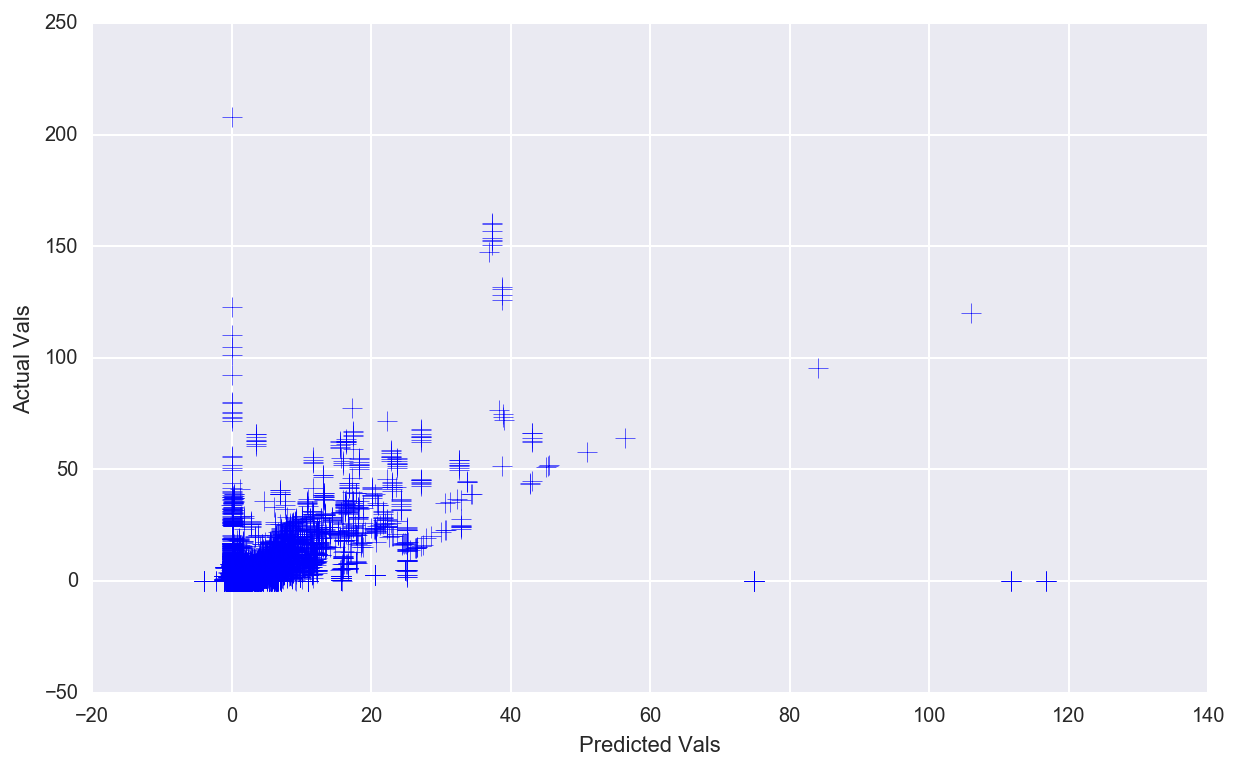

MSE: 0.62822508014
R2: 0.37177491986
Coeffs: [[ 0.02821435  0.03082419  0.03883878  0.53220844  0.04357541 -0.00712429
   0.01949659  0.03102723  0.00194395 -0.01139667  0.20342871]]
intercept: [  3.10404479e-16]


In [123]:
# Linear Regression

lm = linear_model.LinearRegression()
model = lm.fit(X_norm,y_norm)
predictions = lm.predict(X_norm)
fig = plt.figure(figsize = (10,6))
plt.scatter(predictions, y_norm, s=100, c='b', marker = '+')
plt.xlabel("Predicted Vals")
plt.ylabel("Actual Vals")
sns.plt.show()

print "MSE:", mean_squared_error(y_norm, predictions)
print "R2:", model.score(X_norm,y_norm)
print "Coeffs:", model.coef_
print "intercept:", lm.intercept_

In [124]:
# SMF OLS Summary

X2 = assessor[["RP1DOCNO2", "ROOMS", "STOREYNO", "SQFT", "UNITS", "BATHS", "YRBLT",
             "FRONT", "DEPTH", "BEDS", "RP1EXMVL2", "VALUE"]]

lma = smf.ols(formula = 'VALUE ~ RP1DOCNO2 + ROOMS + STOREYNO + SQFT + UNITS + BATHS + \
              YRBLT + FRONT + DEPTH + BEDS + RP1EXMVL2', 
              data = X2).fit()
lma.params
lma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  VALUE   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                 8.094e+04
Date:                Mon, 03 Oct 2016   Prob (F-statistic):               0.00
Time:                        17:55:25   Log-Likelihood:            -2.5238e+07
No. Observations:             1504564   AIC:                         5.048e+07
Df Residuals:                 1504552   BIC:                         5.048e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -1.817e+07   2.93e+05    -62.013      0.000     -1.87e+07 -1.76e+07
RP1DOCNO2    431.5287      9.898     43.599      0.000       412.130   450.928
ROOMS       8012.6559    202.298     39.608      0.000      7616.158  8409.153
STOREYNO    3.957e+04    662.638     59.720      0.000      3.83e+04  4.09e+04
SQFT         146.2187      0.189    771.864      0.000       145.847   146.590
UNITS       1.646e+04    271.635     60.591      0.000      1.59e+04   1.7e+04
BATHS      -4690.6947    529.681     -8.856      0.000     -5728.851 -3652.538
YRBLT       3620.0627    120.181     30.122      0.000      3384.512  3855.613
FRONT       2.339e+05   4881.793     47.923      0.000      2.24e+05  2.44e+05
DEPTH        849.1696    282.310      3.008      0.003       295.852  1402.487
BEDS       -6296.7011    359.769    -17.502      0.000     -7001.836 -5591.567
RP1EXMVL2      0.8875      0.003    313.756      0.000         0.882     0.893
==============================================================================
Omnibus:                  4468697.007   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    7862348272817.595
Skew:                          41.258   Prob(JB):                         0.00
Kurtosis:                   11201.623   Cond. No.                     2.55e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

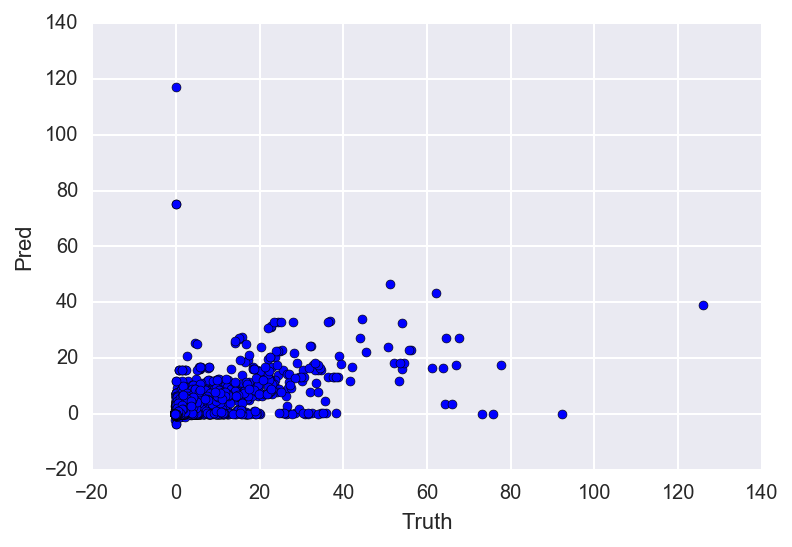

TTS score: 0.385104603091
Training:  0.829967361335
Testing:  0.668473019431


In [125]:
# Train Test Split using Linear Regression

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

lm_tts = linear_model.LinearRegression()
model = lm_tts.fit(X_train, y_train)
predictions_tts = lm_tts.predict(X_test)

plt.scatter(y_test, predictions_tts)
plt.xlabel("Truth")
plt.ylabel("Pred")
sns.plt.show()


print "TTS score:", model.score(X_test, y_test)
print "Training: ", mean_squared_error(y_train, lm_tts.predict(X_train)) ** .5
print "Testing: ", mean_squared_error(predictions_tts, y_test) ** .5

In [126]:
ridge_prices = RidgeCV(store_cv_values=False)
ridge_prices.fit(X_train, y_train)

y_train_ridge_pred = ridge_prices.predict(X_train)
y_test_ridge_pred = ridge_prices.predict(X_test)

print "Lambda Value: ", ridge_prices.alpha_
print "Training: ", mean_squared_error(y_train_ridge_pred, y_train) ** .5
print "Testing: ", mean_squared_error(y_test_ridge_pred, y_test) ** .5

Lambda Value:  10.0
Training:  0.82996736135
Testing:  0.668472883642


In [127]:
lasso_prices = LassoCV(n_alphas=100, cv=3)
lasso_prices.fit(X_train, y_train)

y_train_lasso_pred = lasso_prices.predict(X_train)
y_test_lasso_pred = lasso_prices.predict(X_test)

print "Lambda Value: ", 1 / lasso_prices.alpha_
print "Training: ", mean_squared_error(y_train_lasso_pred, y_train) ** .5
print "Testing: ", mean_squared_error(y_test_lasso_pred, y_test) ** .5

/Users/ga/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lambda Value:  189.556386681
Training:  0.830108207522
Testing:  0.668164539429


In [128]:
enet_prices = ElasticNetCV(l1_ratio = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1] , n_alphas= 100, cv=3)
enet_prices.fit(X_train, y_train)

y_train_enet_pred = enet_prices.predict(X_train)
y_test_enet_pred = enet_prices.predict(X_test)

print "Alpha Value: ", lasso_prices.alpha_
print "Training: ", mean_squared_error(y_train_enet_pred, y_train) ** .5
print "Testing: ", mean_squared_error(y_test_enet_pred, y_test) ** .5

/Users/ga/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Alpha Value:  0.00527547511063
Training:  0.830209907854
Testing:  0.668057962349


Cross-validated score: [ 0.40964049  0.21451741  0.30739875  0.4565487   0.39534839]


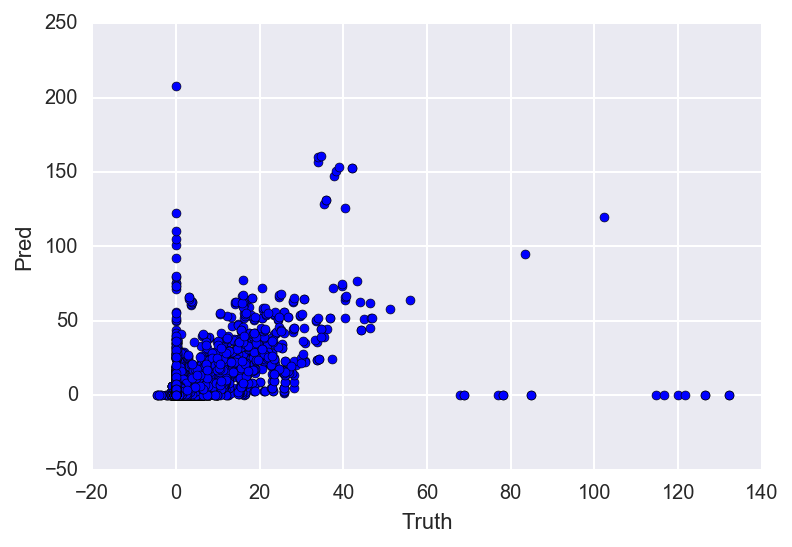

Cross-Predicted Accuracy: 0.355444942417
K-Fold Mean Scores: 0.356690746068


In [129]:
# K-Fold Cross-Validation using Linear Regression

lm_cv = linear_model.LinearRegression()
scores = cross_val_score(lm_cv, X_norm, y_norm, cv = 5)
print "Cross-validated score:", scores

predictions_cross = cross_val_predict(lm_cv, X_norm, y_norm, cv = 5)
plt.scatter(predictions_cross, y_norm)
plt.xlabel("Truth")
plt.ylabel("Pred")
sns.plt.show()

accuracy = metrics.r2_score(y_norm, predictions_cross)
print "Cross-Predicted Accuracy:", accuracy
print "K-Fold Mean Scores:", np.mean(scores)

In [7]:
# Ridge visualization

n_alphas = 200
alphas = np.logspace(1, 10, n_alphas)
clf = linear_model.Ridge(fit_intercept=False)

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y)
    coefs.append(clf.coef_)
print X.shape, y.shape

coefs = np.array(coefs)[:, 0, :]

(1504564, 11) (1504564, 1)


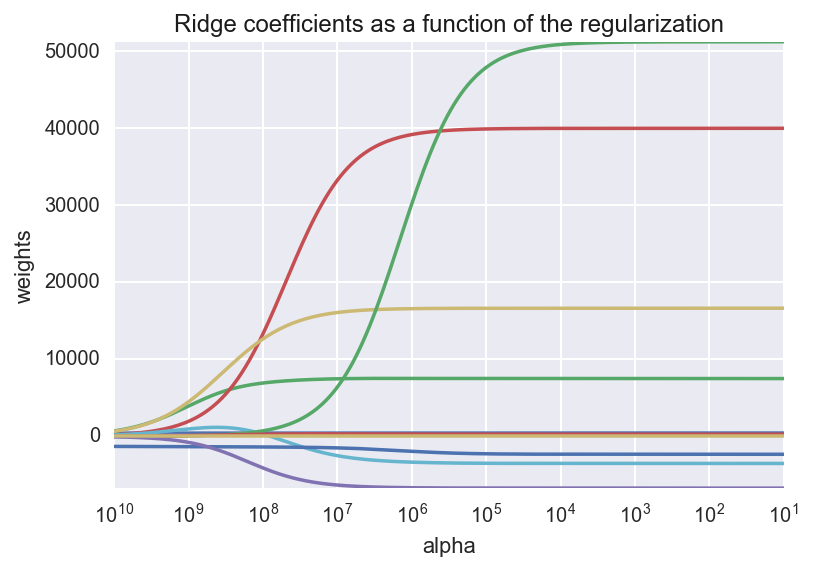

In [8]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


ValueError: x and y must have same first dimension

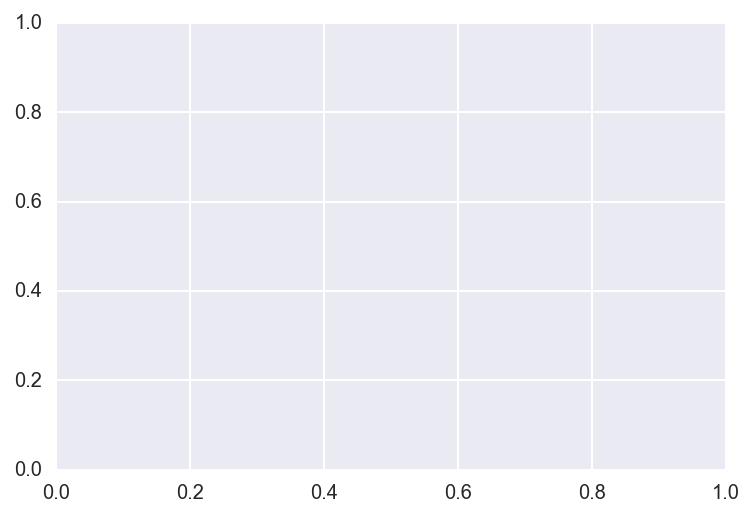

In [25]:
# Visualize Lasso and Elastic
# ERROR... ValueError: x and y must have same first dimension

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X, y, eps, positive=True, fit_intercept=False)
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

# Display results

plt.figure(1)
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')

In [ ]:
# 2.2

# 1) Put simply, a negative R2 value means a horizontal line fits the data
#    better than your model; it represents worse than random predictions
# 2) If the model is a very poor predictor with the test set, 
#    then the residuals can actually be larger than the total variation in test set.

In [ ]:
#####################################################################################
# 8

In [47]:
health_data = pd.read_csv('http://assets.datacamp.com/blog_assets/chol.txt', sep=' ')

In [48]:
health_data.mean()

AGE        35.715
HEIGHT    172.350
WEIGHT     75.885
CHOL      233.600
dtype: float64

In [49]:
health_data.std()

AGE        9.604426
HEIGHT     6.773990
WEIGHT    10.442076
CHOL      44.766732
dtype: float64

In [50]:
health_data.columns

Index([u'AGE', u'HEIGHT', u'WEIGHT', u'CHOL', u'SMOKE', u'BLOOD', u'MORT'], dtype='object')

In [51]:
smoke_dict = {"nonsmo": 0, "sigare": 1, "pipe": 1}
alive_dict = {"alive": 0, "dead": 1}
health_data["SMOKE"] = health_data["SMOKE"].replace(smoke_dict)
health_data["MORT"] = health_data["MORT"].replace(alive_dict)

In [52]:
health_data.corr()

,AGE,HEIGHT,WEIGHT,CHOL,SMOKE,MORT
AGE,1.000000,-0.274894,0.053034,0.454691,0.060716,0.245466
HEIGHT,-0.274894,1.000000,0.491970,-0.287539,0.082843,-0.066947
WEIGHT,0.053034,0.491970,1.000000,-0.034337,0.014917,0.058734
CHOL,0.454691,-0.287539,-0.034337,1.000000,0.100336,0.158707
SMOKE,0.060716,0.082843,0.014917,0.100336,1.000000,0.067257
MORT,0.245466,-0.066947,0.058734,0.158707,0.067257,1.000000


In [53]:
health_data.groupby("SMOKE")["MORT"].sum()

SMOKE
0     4
1    20
Name: MORT, dtype: int64

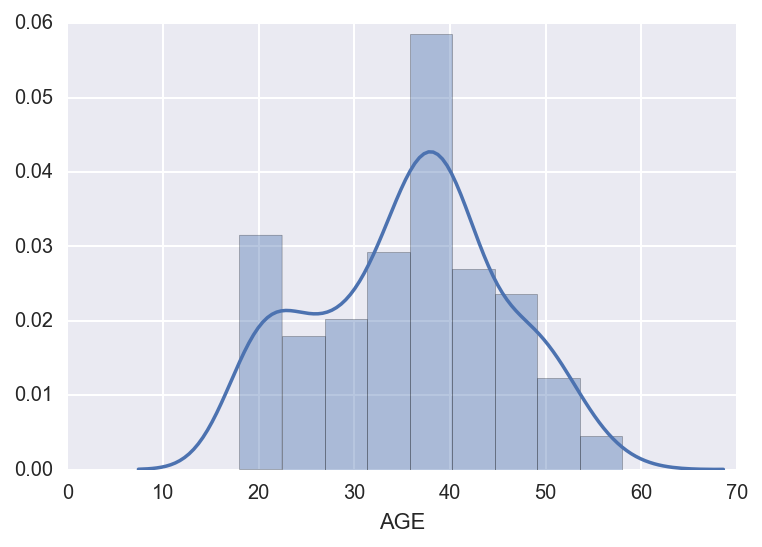

In [58]:
sns.distplot(health_data["AGE"])

In [62]:
import statsmodels.stats.api as sms
sms.DescrStatsW(health_data["WEIGHT"]).tconfint_mean()

(74.428973734623938, 77.341026265376073)

In [63]:
from scipy import stats

In [65]:
stats.ttest_1samp(health_data["WEIGHT"], 85.0)

Ttest_1sampResult(statistic=-12.344821194685455, pvalue=2.2901936138582111e-26)

In [ ]:
#7
#1) One bias is the assumption that the user has friends, or that the user's friends
#   aren't already glued to another similar app; another is that they're assuming the
#   user's friends will even use the app
#2) You could measure success by counting the friends who use the app at least 5 times
#3) Offer friends/spouse/family
#4) What lol this seems political/personal/biased from all angles